In [17]:
import mne
import matplotlib.pyplot as plt
import numpy as np

from scipy.signal import spectrogram, get_window
from IPython.display import Audio

# Función para graficar el espectrograma
def plot_spectrogram(signal, sample_rate, overlapping = 0., window_type='hann', window_size=256):
    """
    Genera y grafica el espectrograma de una señal.

    Parámetros:
    - signal: la señal de audio
    - window_type: el tipo de ventana a usar (string, por ejemplo 'hann', 'hamming', etc.)
    - window_size: tamaño de la ventana (entero)
    - overlapping: porcentaje de solapamiento (valor entre 0 y 1)
    - fs: frecuencia de muestreo de la señal
    """
    # Crear la ventana
    window = get_window(window_type, window_size)

    # Calcular el paso de la ventana en función del solapamiento
    noverlap = int(overlapping * window_size)

    # Calcular el espectrograma usando scipy.signal.spectrogram
    f, t, Sxx = spectrogram(signal, fs=sample_rate, window=window,
                            nperseg=window_size, noverlap=noverlap)


    # Graficar el espectrograma
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.title('Espectrograma')
    plt.ylabel('Frecuencia [Hz]')
    plt.xlabel('Tiempo [s]')
    plt.colorbar(label='Amplitud [dB]')
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(30000,)


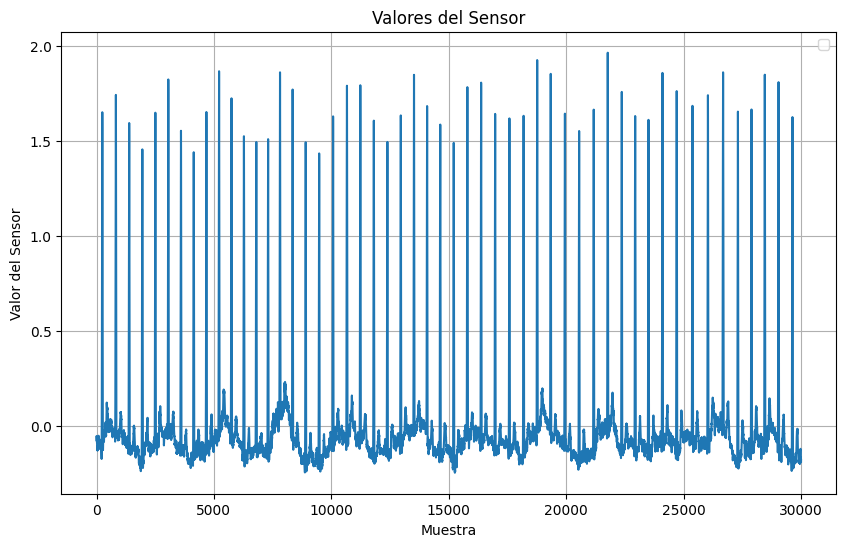

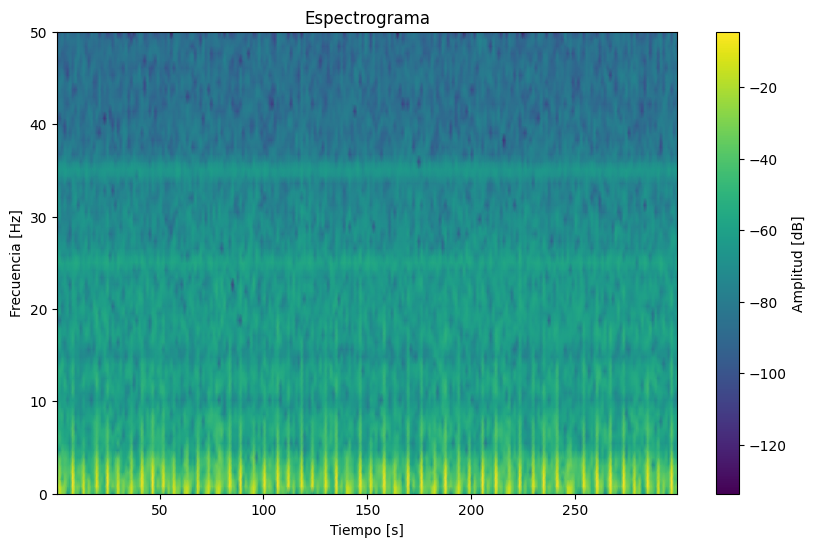

In [18]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

# Abre el archivo .dat en modo binario
record_name = 'NIFAECG/NR_02'

# Cargar el archivo .dat y su metainformación
record = wfdb.rdrecord(record_name)

# Acceder a los datos de la señal
signals = record.p_signal[30000:60000,0]
print(signals.shape)

# Graficar los valores del sensor
plt.figure(figsize=(10, 6))
plt.plot(signals)
plt.xlabel('Muestra')
plt.ylabel('Valor del Sensor')
plt.title('Valores del Sensor')
plt.legend()
plt.grid(True)
plt.show()

plot_spectrogram(signals, 100, window_type='hann', window_size=128, overlapping=0.)


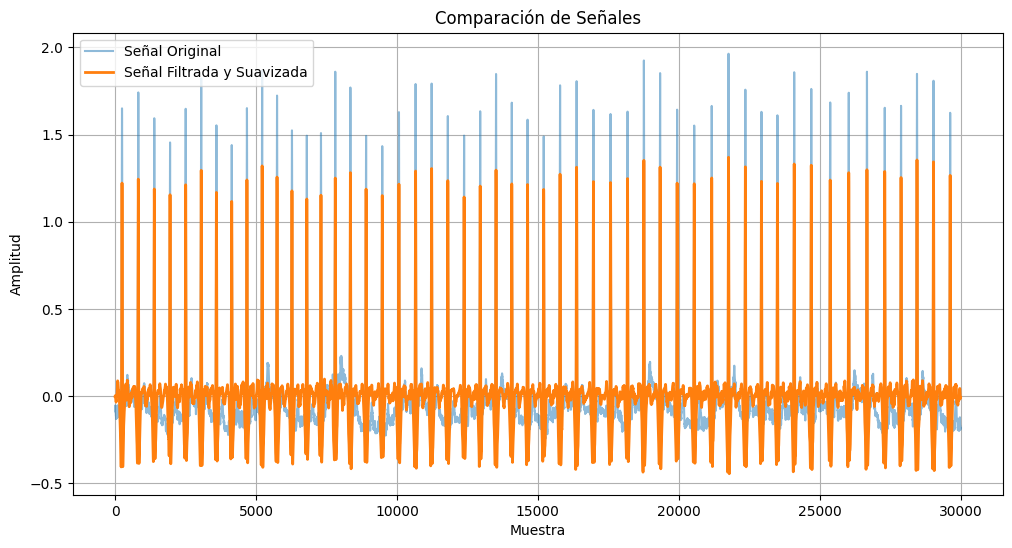

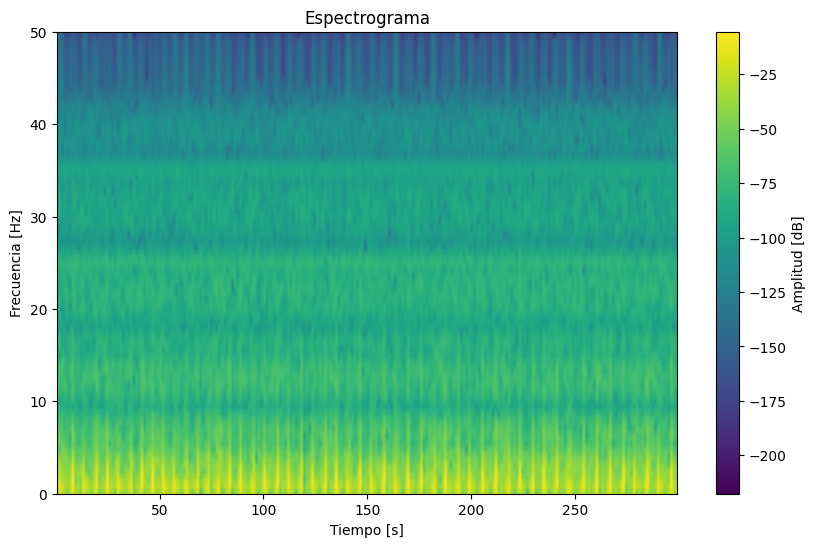

In [19]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, get_window, butter, filtfilt, iirnotch

# Cargar la señal
record_name = 'NIFAECG/NR_02'
record = wfdb.rdrecord(record_name)
signals = record.p_signal[30000:60000, 0]

# Definir funciones de filtrado y suavizado
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, signal)
    return y

def notch_filter(signal, notch_freq, fs, Q=30):
    nyquist = 0.5 * fs
    freq = notch_freq / nyquist
    b, a = iirnotch(freq, Q)
    y = filtfilt(b, a, signal)
    return y

def smooth_signal(signal, window_len=11):
    window = np.ones(window_len) / window_len
    y = np.convolve(signal, window, mode='same')
    return y

# Parámetros
fs = 100
lowcut = 0.5
highcut = 40  # Ensure highcut is less than Nyquist frequency (fs/2)
notch_freq = 50

# Procesamiento de la señal
bandpassed_signal = bandpass_filter(signals, lowcut, highcut, fs)
notched_signal = notch_filter(bandpassed_signal, notch_freq, fs)
smoothed_signal = smooth_signal(notched_signal, window_len=11)

# Visualización
plt.figure(figsize=(12, 6))
plt.plot(signals, label='Señal Original', alpha=0.5)
plt.plot(smoothed_signal, label='Señal Filtrada y Suavizada', linewidth=2)
plt.xlabel('Muestra')
plt.ylabel('Amplitud')
plt.title('Comparación de Señales')
plt.legend()
plt.grid(True)
plt.show()

# Espectrograma
def plot_spectrogram(signal, sample_rate, overlapping=0., window_type='hann', window_size=256):
    window = get_window(window_type, window_size)
    noverlap = int(overlapping * window_size)
    f, t, Sxx = spectrogram(signal, fs=sample_rate, window=window,
                            nperseg=window_size, noverlap=noverlap)
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.title('Espectrograma')
    plt.ylabel('Frecuencia [Hz]')
    plt.xlabel('Tiempo [s]')
    plt.colorbar(label='Amplitud [dB]')
    plt.show()

plot_spectrogram(smoothed_signal, fs, window_type='hann', window_size=128, overlapping=0.)


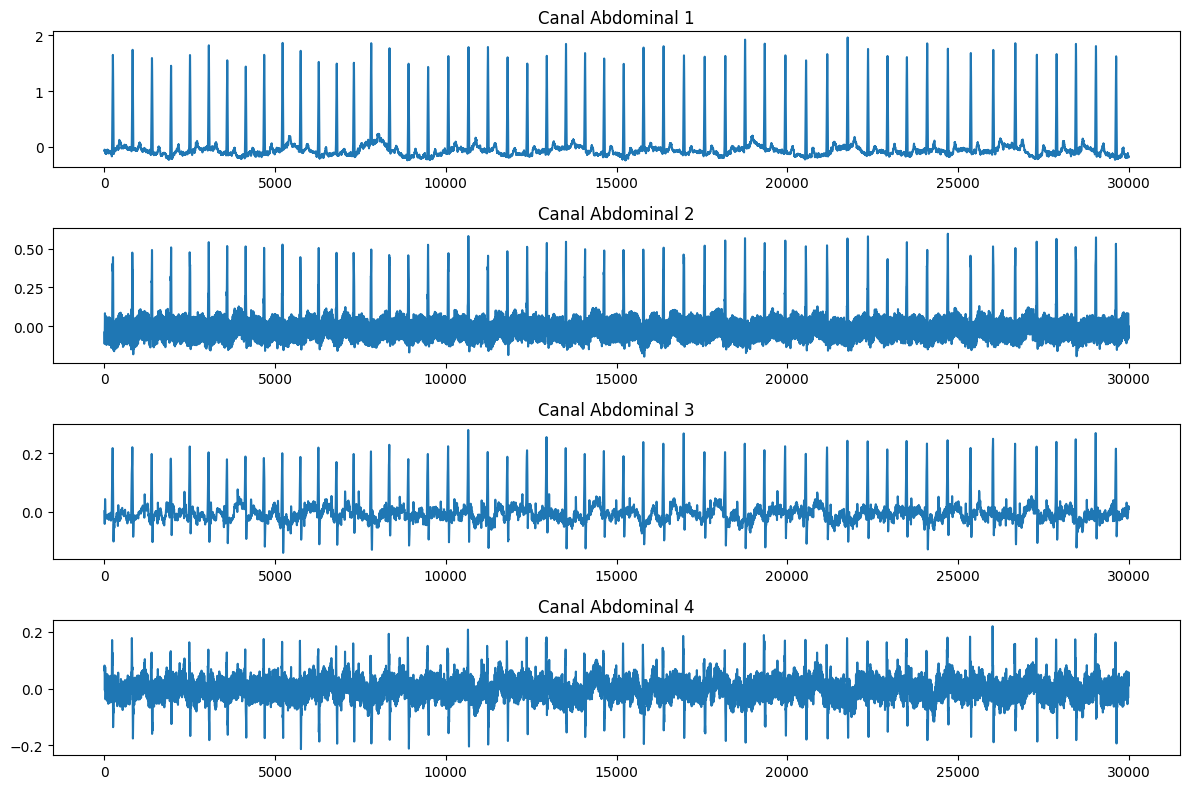

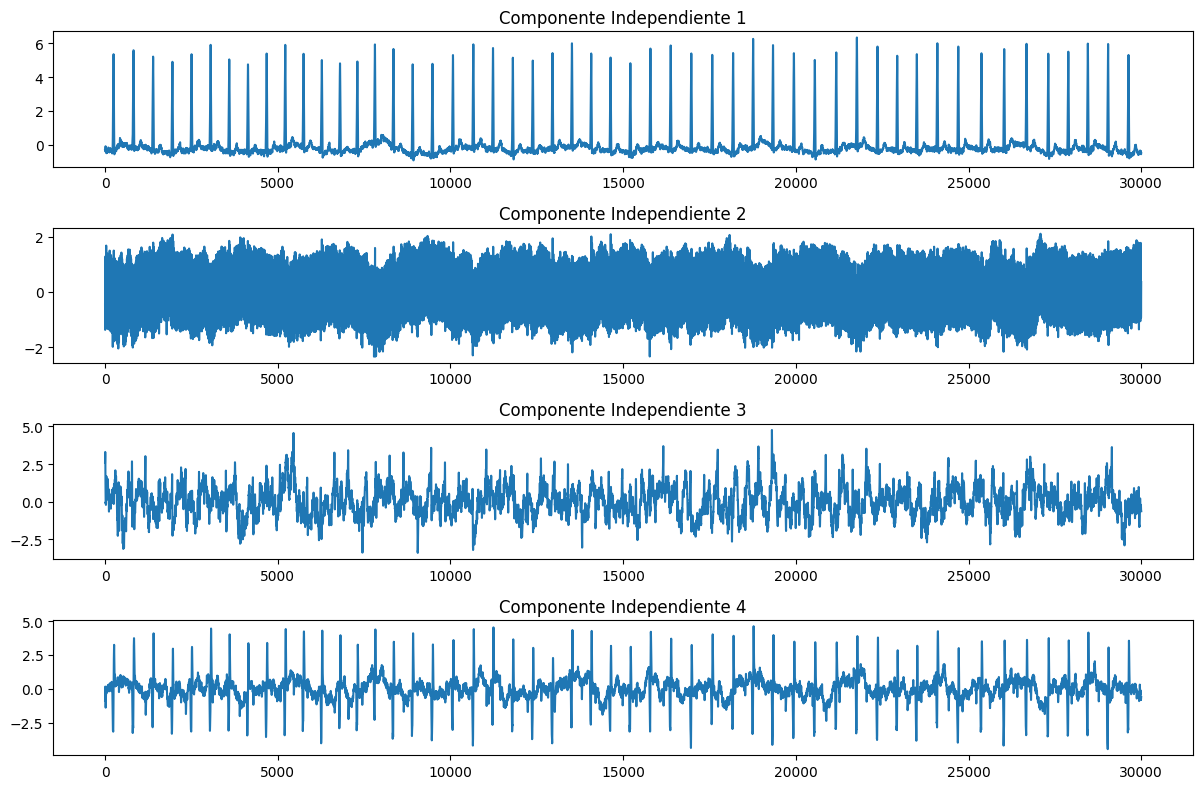

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
import wfdb

# Cargar la señal multicanal
record_name = 'NIFAECG/NR_02'
record = wfdb.rdrecord(record_name)

# Seleccionar los canales abdominales (por ejemplo, los canales 0 a 3)
abdominal_signals = record.p_signal[30000:60000, 0:4]

# Visualizar las señales abdominales originales
plt.figure(figsize=(12, 8))
for i in range(abdominal_signals.shape[1]):
    plt.subplot(abdominal_signals.shape[1], 1, i+1)
    plt.plot(abdominal_signals[:, i])
    plt.title(f'Canal Abdominal {i+1}')
    plt.tight_layout()
plt.show()

# Aplicar ICA
ica = FastICA(n_components=4, random_state=0)
S_ica = ica.fit_transform(abdominal_signals)  # Componentes independientes

# Visualizar las componentes independientes
plt.figure(figsize=(12, 8))
for i in range(S_ica.shape[1]):
    plt.subplot(S_ica.shape[1], 1, i+1)
    plt.plot(S_ica[:, i])
    plt.title(f'Componente Independiente {i+1}')
    plt.tight_layout()
plt.show()


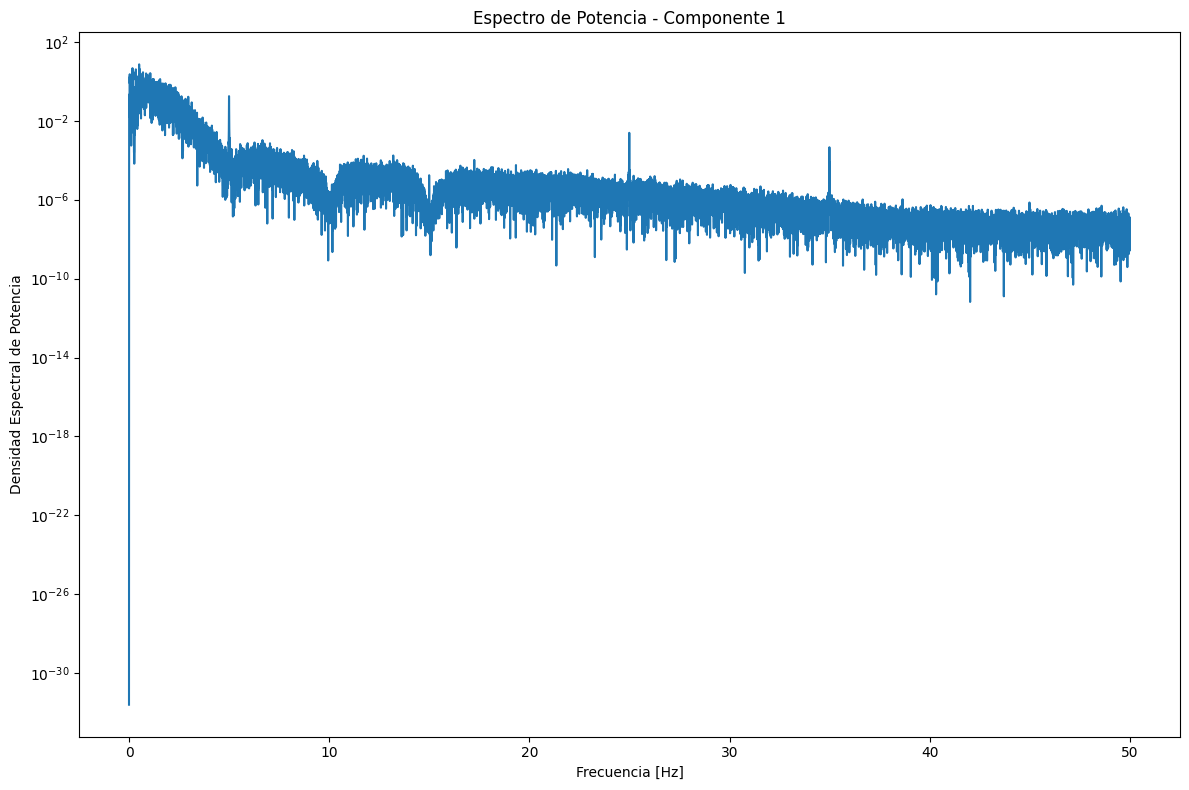

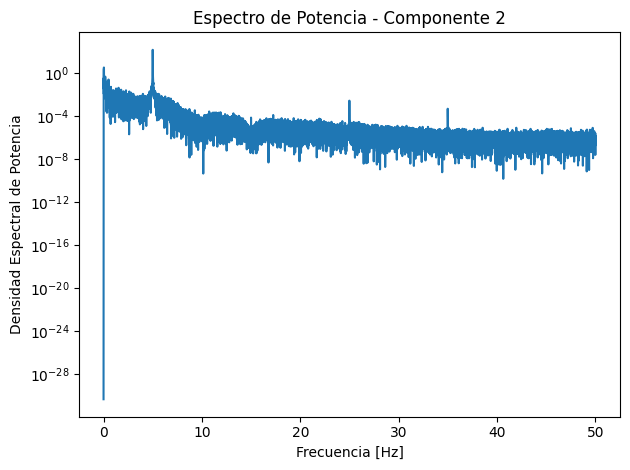

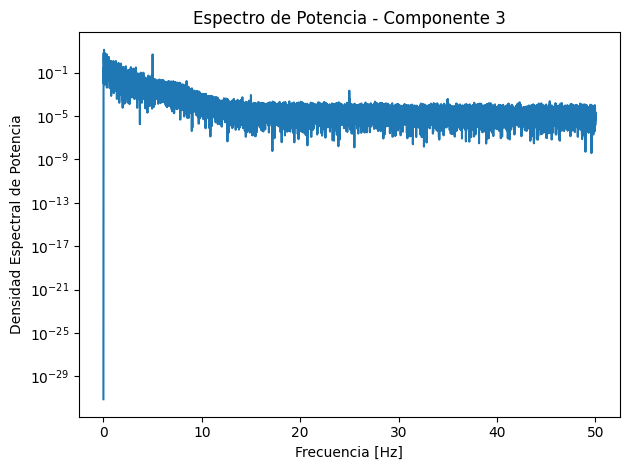

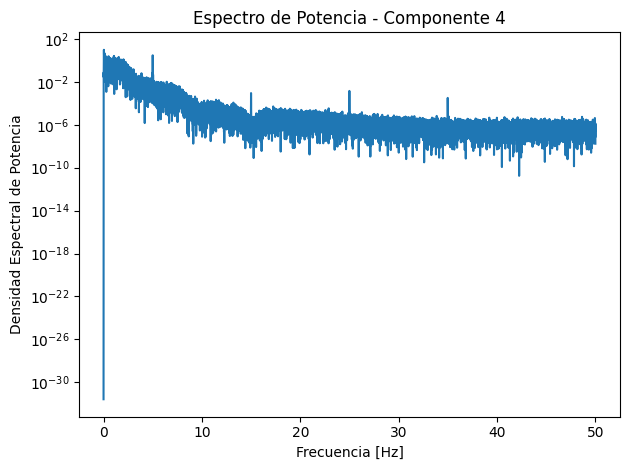

In [21]:
from scipy.signal import periodogram

fs = 100  # Frecuencia de muestreo
plt.figure(figsize=(12, 8))
for i in range(S_ica.shape[1]):
    f, Pxx = periodogram(S_ica[:, i], fs)
    plt.semilogy(f, Pxx)
    plt.title(f'Espectro de Potencia - Componente {i+1}')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Densidad Espectral de Potencia')
    plt.tight_layout()
    plt.show()


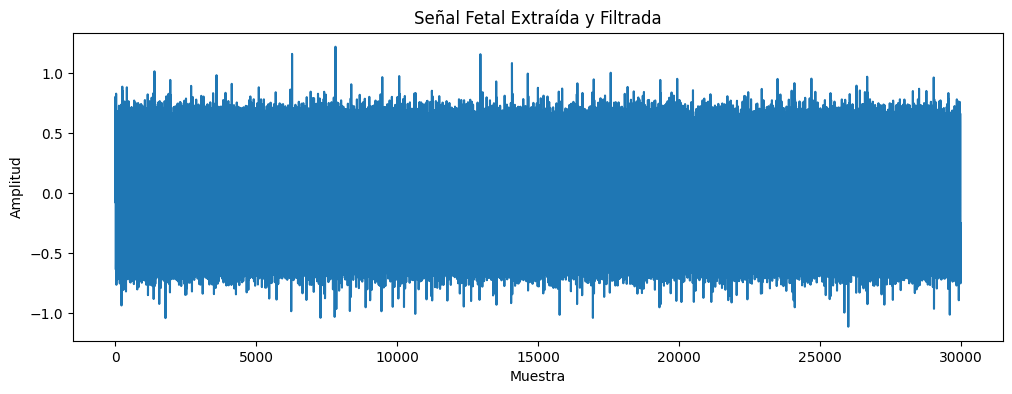

In [22]:
# Supongamos que la señal fetal está en la componente 2
fetal_component = S_ica[:, 1]

# Filtrar la señal fetal para mejorar la calidad
from scipy.signal import butter, filtfilt

def bandpass_filter(signal, lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, signal)
    return y

# Aplicar un filtro pasabanda entre 1 y 5 Hz
fetal_signal = bandpass_filter(fetal_component, 1, 5, fs)

# Visualizar la señal fetal filtrada
plt.figure(figsize=(12, 4))
plt.plot(fetal_signal)
plt.title('Señal Fetal Extraída y Filtrada')
plt.xlabel('Muestra')
plt.ylabel('Amplitud')
plt.show()


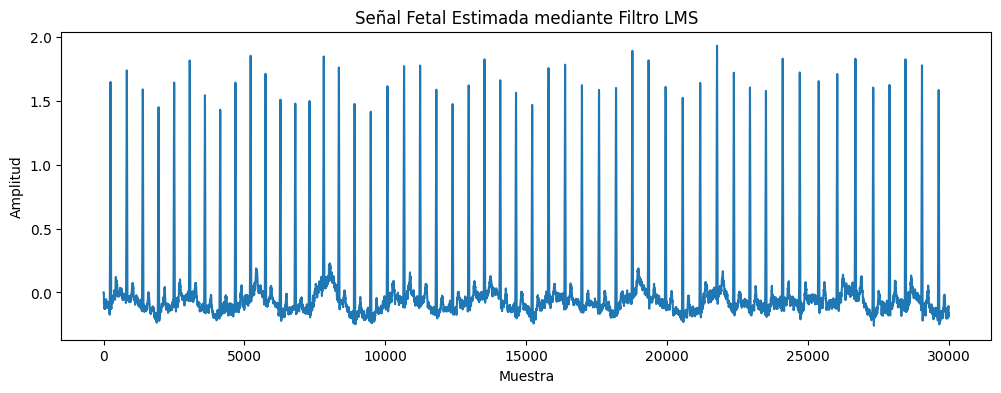

In [23]:
# Supongamos que el canal 4 es una derivación torácica (señal materna)
maternal_reference = record.p_signal[30000:60000, 4]

# Señal primaria (mezcla de señales materna y fetal)
primary_signal = abdominal_signals[:, 0]  # Usaremos el primer canal abdominal

# Parámetros del filtro LMS
mu = 0.0001  # Tasa de aprendizaje (ajusta según sea necesario)
filter_order = 12  # Orden del filtro (ajusta según sea necesario)

# Inicializar variables
n_samples = len(primary_signal)
weights = np.zeros(filter_order)
output = np.zeros(n_samples)
error = np.zeros(n_samples)

# Algoritmo LMS
for n in range(filter_order, n_samples):
    x = maternal_reference[n-filter_order:n]  # Ventana de la señal de referencia
    y = np.dot(weights, x)  # Salida del filtro
    e = primary_signal[n] - y  # Error entre la señal primaria y la salida del filtro
    weights += 2 * mu * e * x  # Actualización de pesos
    output[n] = y
    error[n] = e  # Señal estimada (señal fetal)

# Visualizar la señal fetal estimada
plt.figure(figsize=(12, 4))
plt.plot(error)
plt.title('Señal Fetal Estimada mediante Filtro LMS')
plt.xlabel('Muestra')
plt.ylabel('Amplitud')
plt.show()


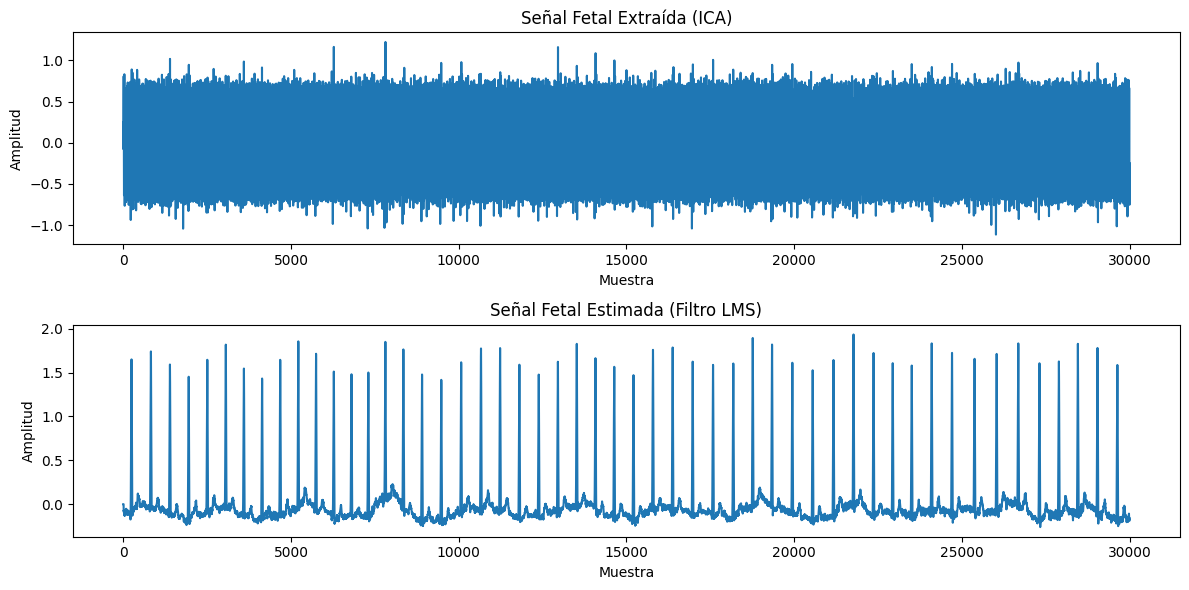

In [24]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(fetal_signal)
plt.title('Señal Fetal Extraída (ICA)')
plt.xlabel('Muestra')
plt.ylabel('Amplitud')

plt.subplot(2, 1, 2)
plt.plot(error)
plt.title('Señal Fetal Estimada (Filtro LMS)')
plt.xlabel('Muestra')
plt.ylabel('Amplitud')

plt.tight_layout()
plt.show()
